##### **Good luck with taking your exam. Keep working and make your dreams all come true. Seeing the results of all of your hard work will make this struggle worth it. We’re all thinking of you.** 
<b><font color='blue'>AI-PRO Spark Team ITI</font></b>

## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

## To perform this task follow the following guiding steps:

In [1]:
!pip install pyspark

In [2]:
!pip install pyspark_dist_explore

### Create a spark session and import the required libraries

In [250]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType,IntegerType, StringType, StructType, StructField
spark = SparkSession.builder.getOrCreate()

### Create a data schema programatically

In [251]:
#df = spark.read.csv("/content/healthcare-dataset-stroke-data.csv", header="true", inferSchema="true")
#df.printSchema()
schema =StructType([
        StructField('id',IntegerType()),
         StructField('gender',StringType()),
         StructField('age',DoubleType()),
         StructField('hypertension',IntegerType()),
         StructField('heart_disease',IntegerType()),
         StructField('ever_married',StringType()),
         StructField('work_type',StringType()),
         StructField('Residence_type',StringType()),
         StructField('avg_glucose_level',DoubleType()),
         StructField ('bmi',StringType()),
         StructField ('smoking_status',StringType()),
         StructField('stroke',IntegerType())

])

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [252]:
df = spark.read.csv("healthcare-dataset-stroke-data.csv", header="true", schema= schema)


### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [253]:
df.printSchema()
df.show(10)
null_columns = []
for col_name in df.columns:
    null_values = df.where((F.col(col_name).isNull())|(F.col(col_name)=='N/A')|(F.col(col_name)=='null')).count()
    if(null_values > 0):
        null_columns.append((col_name, null_values))
print(null_columns)

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|  

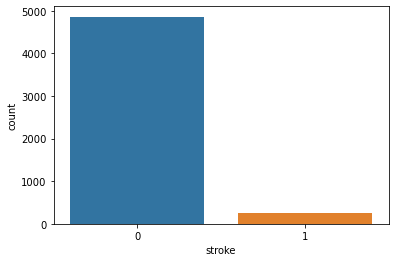

In [254]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
countplot =df.toPandas()


sns.countplot(x="stroke", data=countplot)
plt.show()

In [255]:
countplot['stroke'].value_counts()


0    4861
1     249
Name: stroke, dtype: int64

### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [256]:
df.describe('age').show()
df1 = df.filter('age >=2')
df1.describe('age').show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              4990|
|   mean| 44.23907815631262|
| stddev|21.908077881917443|
|    min|               2.0|
|    max|              82.0|
+-------+------------------+



### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [257]:
df1.select('gender','smoking_status').show(20)

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [258]:
df1.select('gender').distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [259]:
df1.select('smoking_status').distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [260]:
Gender_map = {
 
 'Male': 1,
 'Female': 0,
 'Other': 0,
 
}

Smoking_map = {
 
 'smokes': 1.0,
 'never smoked': 0.0,
 'formerly smoked' : 0.75,
 'Unknown' :0.5
 
}

def impute_title(title):
    return Gender_map[title]
def impute_title2(title):
    return Smoking_map[title]

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [261]:
title_map_func = F.udf(lambda x: impute_title(x), IntegerType())
df1 = df1.withColumn('gender', title_map_func('gender'))


title_map_func = F.udf(lambda x: impute_title2(x), DoubleType())

df1 = df1.withColumn('smoking_status', title_map_func('smoking_status'))


In [262]:
df1.select('gender','smoking_status').show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



In [263]:
df1.dtypes

[('id', 'int'),
 ('gender', 'int'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'string'),
 ('smoking_status', 'double'),
 ('stroke', 'int')]

### Deal with null value according to your data analysis.

In [264]:
df1.createOrReplaceTempView('combined')

round(spark.sql("SELECT AVG(bmi) FROM combined").collect()[0][0])


29

In [265]:

from pyspark.sql.functions import when

combined = df1.withColumn("bmi", when(df1["bmi"] == 'N/A', '29').otherwise(df1["bmi"]))
combined = combined.withColumn("bmi",combined["bmi"].cast(DoubleType()))
#combined = df1['bmi'].map('N/A','29')
combined.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
| 9046|     1|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|          0.75|     1|
|51676|     0|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|29.0|           0.0|     1|
|31112|     1|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|           0.0|     1|
|60182|     0|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|           1.0|     1|
| 1665|     0|79.0|           1|            0|         Yes|Sel

### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [266]:
X_train, X_test = combined.randomSplit([0.8, 0.2],seed = 42)
X_train.write.parquet("train.parquet")
X_test.write.parquet("test.parquet")

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [312]:
X_train=spark.read.parquet("train.parquet")
X_test=spark.read.parquet("test.parquet")

### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [313]:
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression


In [314]:
combined.dtypes

[('id', 'int'),
 ('gender', 'int'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'double'),
 ('smoking_status', 'double'),
 ('stroke', 'int')]

In [315]:
categoricalCols = [field for (field, dataType) in combined.dtypes
                   if dataType == "string"]
categoricalCols

['ever_married', 'work_type', 'Residence_type']

In [316]:
numericCols = [field for (field,dataType) in combined.dtypes
              if (((dataType=='double')|(dataType=='int'))& (field!='stroke')&(field!='id'))]
numericCols

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'smoking_status']

In [317]:
indexOutputCols = [x + "_Index" for x in categoricalCols]
print(indexOutputCols)
oheOutputCols = [x + "_OHE" for x in categoricalCols]
print(oheOutputCols)

['ever_married_Index', 'work_type_Index', 'Residence_type_Index']
['ever_married_OHE', 'work_type_OHE', 'Residence_type_OHE']


### String Indexer

In [318]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')

### One hot Encoding

In [319]:
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

### Vector Assembler

In [320]:
assemblerInputs = oheOutputCols + numericCols
assemblerInputs

['ever_married_OHE',
 'work_type_OHE',
 'Residence_type_OHE',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'smoking_status']

In [321]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')
LR =LogisticRegression(featuresCol = 'features', labelCol = 'stroke')
pipeline = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,LR])

predictions = pipeline.fit(X_train)


### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [322]:
predictions=predictions.transform(X_test)
predictions.select("features").show(truncate=False)

+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|(13,[0,1,5,6,7,10,11],[1.0,1.0,1.0,1.0,55.0,89.17,31.5])   |
|(13,[1,5,7,10,11],[1.0,1.0,24.0,97.55,26.2])               |
|(13,[0,1,7,10,11],[1.0,1.0,33.0,86.97,42.2])               |
|(13,[0,1,7,10,11,12],[1.0,1.0,43.0,88.23,37.6,0.5])        |
|(13,[0,1,5,6,7,10,11],[1.0,1.0,1.0,1.0,79.0,198.79,24.9])  |
|(13,[0,1,7,10,11],[1.0,1.0,43.0,110.32,28.4])              |
|(13,[0,2,6,7,8,10,11],[1.0,1.0,1.0,78.0,1.0,75.19,27.6])   |
|(13,[0,2,5,7,10,11],[1.0,1.0,1.0,74.0,74.96,26.6])         |
|(13,[4,7,10,11,12],[1.0,14.0,92.22,22.8,0.5])              |
|(13,[0,1,6,7,10,11,12],[1.0,1.0,1.0,69.0,101.52,26.8,1.0]) |
|(13,[0,3,6,7,10,11,12],[1.0,1.0,1.0,52.0,87.26,40.1,1.0])  |
|(13,[1,7,8,9,10,11,12],[1.0,82.0,1.0,1.0,84.03,26.5,0.75]) |
|(13,[1,6,7,10,11],[1.0,1.0,17.0,81.77,44.7])               |
|(13,[0,

In [323]:
predictions.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- ever_married_Index: double (nullable = false)
 |-- work_type_Index: double (nullable = false)
 |-- Residence_type_Index: double (nullable = false)
 |-- ever_married_OHE: vector (nullable = true)
 |-- work_type_OHE: vector (nullable = true)
 |-- Residence_type_OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [324]:
predictions.select("prediction", "stroke").show()
predictions.select("prediction", "stroke").where((F.col('prediction')==1)&(F.col('stroke')==1)).show()
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction|stroke|
+----------+------+
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     1|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     1|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
+----------+------+
only showing top 20 rows

+----------+------+
|prediction|stroke|
+----------+------+
+----------+------+

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  953|
+----------+-----+



### All predictions are zero!!!

### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [325]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [326]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [327]:
evaluatorROC.evaluate(predictions)

0.5

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
### YOU SHOULD OBTAIN  ROC > 0.65
<BR>
<b><font color='red'>Note: feel free to deal with the imbalanced cluster with the above method or another. However, you can only use methods applied on SPARK DATAFRAME</font></b>

### Add weightCol

In [328]:
X_train.groupBy('stroke').count().show()


+------+-----+
|stroke|count|
+------+-----+
|     1|  202|
|     0| 3835|
+------+-----+



In [329]:
count_ones = X_train.filter('stroke = 1').select('stroke').count()

count_ones

202

In [330]:
count_zeros = X_train.filter('stroke = 0').select('stroke').count()
count_zeros

3835

In [331]:
total = count_ones+ count_zeros
total

4037

In [332]:

getRatio = F.udf(lambda x: count_zeros/total if x ==1 else count_ones/total , DoubleType())
X_train = X_train.withColumn("Ratio", getRatio('stroke'))


In [333]:
X_train.select('stroke','Ratio').show()

+------+-------------------+
|stroke|              Ratio|
+------+-------------------+
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     1| 0.9499628436958137|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
|     0|0.05003715630418628|
+------+-------------------+
only showing top 20 rows



In [342]:

LRW =LogisticRegression(featuresCol = 'features', labelCol = 'stroke', weightCol='Ratio')
pipeline = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,LRW])

predictions = pipeline.fit(X_train)


In [344]:
pred_W=predictions.transform(X_test)
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [345]:
pred_W.filter("prediction = 1").count()


287

In [346]:
pred_W.filter("prediction = 0").count()


666

In [347]:
evaluatorROC.evaluate(pred_W)

0.7757777671252577

### ROC Increased to 0.7758 !!!

# GOOD LUCK
<b><font color='GREEN'>AI-PRO Spark Team ITI</font></b>